# Apply Spectral Differencing to DESI Spectra

Mini-SV2 tiles from February-March 2020:
- https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

See also the DESI tile picker with (limited) SV0 tiles from March 2020:
- https://desi.lbl.gov/svn/data/tiles/trunk/
- https://desi.lbl.gov/svn/data/tiles/trunk/SV0.html

In [1]:
from desispec.io import read_spectra, write_spectra
# from desispec.spectra import Spectra"
# from desitarget.cmx.cmx_targetmask import cmx_mask

# from desitrip.preproc import rebin_flux, rescale_flux

# from astropy.io import fits
# from astropy.table import Table, vstack, hstack

# from glob import glob
import datetime
from astropy.time import Time

# import os
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# import fitsio

# # from tensorflow import keras


import copy

# mpl.rc('font', size=14)

# utility functions
from timedomain.fs_utils import *
from timedomain.sp_utils import *
from timedomain.filters import *
from timedomain.iterators import *
from timedomain.plot_utils import *

In [2]:
logic  = CVLogic
date = "20201223"
subdir = 'daily'
trunk='spectra'

# make this none for results to appear in the notebook
spdf = ["diff",logic.__name__,subdir,trunk,date]
spdf = None
for pspectra0,pspectra1 in Date_SpectraByTarget_Iterator(date,subdir=subdir,trunk='spectra'):


    # which of these are real targets
    triggered, diff = logic.filter(pspectra0,pspectra1, norm=True)

    # plot triggered objects
    if triggered.sum() > 0:
        
        wheretriggered = np.where(triggered)[0]

        for sig in np.nditer(wheretriggered):
            logic.plotter(sig,pspectra0, pspectra1, diff, savepdf=spdf)
    
        wef

Tile 80613
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-0-80613-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-1-80613-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-2-80613-20201223.fits


/global/cscratch1/sd/akim/project/timedomain/timedomain/filters.py:55: RuntimeWarning: divide by zero encountered in true_divide
  s0.ivar[dindex] = s0.ivar[dindex]/((norm*norm)[:,None])
/global/cscratch1/sd/akim/project/timedomain/timedomain/filters.py:55: RuntimeWarning: invalid value encountered in true_divide
  s0.ivar[dindex] = s0.ivar[dindex]/((norm*norm)[:,None])


Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-4-80613-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-5-80613-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-6-80613-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-7-80613-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-8-80613-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/spectra-9-80613-20201223.fits
Tile 80617
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80617/20201223/spectra-0-80617-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80617/20201223/spectra-1-80617-20201223.fits
Filename /global/project/projectdirs/desi/spectro/redux/daily/tiles/80617/20201223/sp

In [1]:
logic  = CVLogic

NameError: name 'CVLogic' is not defined

In [96]:
for i in Date_Spectra_Iterator("20201223",subdir='daily',trunk='coadd'):
    print (i)

(<desispec.spectra.Spectra object at 0x2aaae74dfdf0>, '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/coadd-0-80613-20201223.fits')
(<desispec.spectra.Spectra object at 0x2aaade48aee0>, '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/coadd-1-80613-20201223.fits')
(<desispec.spectra.Spectra object at 0x2aaade1273a0>, '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/coadd-2-80613-20201223.fits')
(<desispec.spectra.Spectra object at 0x2aaade127640>, '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/coadd-4-80613-20201223.fits')
(<desispec.spectra.Spectra object at 0x2aaade464970>, '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/coadd-5-80613-20201223.fits')
(<desispec.spectra.Spectra object at 0x2aaade255df0>, '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80613/20201223/coadd-6-80613-20201223.fits')
(<desispec.spectra.Spectra object at 0x2aab34a

In [97]:
logic = CVLogic

today = datetime.date.today()
date = today.strftime("%Y%m%d")
date="20201223"

iterator = DailyPairs(date)
for i in iterator:
    print(i)

None


TypeError: expected str, bytes or os.PathLike object, not NoneType

## Save to PDF or not

### Iterator that returns pairs of Spectra
Examples all tiles observed on a date, a coadds for a tile, all single exposures for a tile/date, all coadds for a TARGETID

daily / build

In [ ]:
### Class containing selection logic
Examples: CV, single resolution element

Renormalized / unnormalized

In [ ]:

# if not set aas keyword loops through all dates
dates =('20200304','20200305')

logic = CVLogic

for (pspectra0,pspectra1) in iterator:
    # which of these are real targets
    fibermap = pspectra0.fibermap #Table.read(datafile0, 'FIBERMAP')
    isTGT = fibermap['OBJTYPE'] == 'TGT'
    # the interesting guy is wedge 6 index 331
#     print(fibermap['TARGETID'].data[0], np.where(fibermap['TARGETID'].data== 35191288252861933)[0])
#     pspectra0 = read_spectra(datafile0)
#     pspectra1 = read_spectra(datafile1)
    hasSignal = HasSignal.filter(pspectra0,pspectra1)

    pspectra0, pspectra1 = renorm(pspectra0,pspectra1)
    
    diff = difference(pspectra0,pspectra1)
    significant = logic.filter(diff)

#     if 35191288252861933 in fibermap['TARGETID'].data:
#         print(hasSignal[331], significant[331])
        
    triggered = np.logical_and.reduce((significant, isTGT, hasSignal))

    # plot triggered objects
    print(triggered.sum(),datafile0,datafile1)
    if triggered.sum() > 0:
        wheretriggered = np.where(triggered)[0]

        for sig in np.nditer(wheretriggered):
            diffplot(sig,pspectra0, pspectra1, diff)

if makepdf:
    pdf.close()
    print (c)
    

In [69]:
# get wedges available for each date
wedges=[]
for obsdate in obsdates:
    cafiles = sorted(glob('{}/{}/coadd*.fits'.format(prefix_in,obsdate)))
    pas = []
    for cafile in cafiles:
        index0 = cafile.find('coadd-')
        index1 = cafile.find('-',index0+6)
        pas.append(cafile[index0+6:index1])
    wedges.append(pas)
    
wedges

[['0', '1', '3', '5', '6', '7', '8', '9'],
 ['0', '3', '6', '7', '8', '9'],
 ['0', '3', '6', '7', '9']]

# From here on out are remnants of Segev's original code, which I keep in case needed later

In [ ]:
# List zbest and coadd files.
# Data are stored by petal ID.
zbfiles = sorted(glob('{}/zbest*.fits'.format(prefix_in)))
cafiles = sorted(glob('{}/coadd*.fits'.format(prefix_in)))

In [ ]:
# zbest files from redrock.
zbfiles

In [ ]:
# Co-added spectra from multiple exposures + the three spectrograph arms.
cafiles

## Load the Keras Model

Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.

In [ ]:
tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
# tfmodel = '/'.join([os.environ['HOME'], 'desi/timedomain/desitrip/docs/nb', '6label_cnn_restframe'])
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

In [104]:
if classifier is not None:
    classifier.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 8)            32        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 16)            64    

## Loop Through Spectra and Classify

In [105]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None

In [106]:
for cafile, zbfile in zip(cafiles, zbfiles):
    # Access data per petal.
    zbest = Table.read(zbfile, 'ZBEST')
    fibermap = Table.read(zbfile, 'FIBERMAP')
    pspectra = read_spectra(cafile)

    # Apply standard event selection.
    isTGT = fibermap['OBJTYPE'] == 'TGT'
    isGAL = zbest['SPECTYPE'] == 'GALAXY'
    isBGS = fibermap['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    select = isTGT & isGAL & isBGS

    # Accumulate spectrum data.
    if allzbest is None:
        allzbest = zbest[select]
        allfmap = fibermap[select]
        allwave = pspectra.wave['brz']
        allflux = pspectra.flux['brz'][select]
        allivar = pspectra.ivar['brz'][select]
        allmask = pspectra.mask['brz'][select]
        allres  = pspectra.resolution_data['brz'][select]
    else:
        allzbest = vstack([allzbest, zbest[select]])
        allfmap = vstack([allfmap, fibermap[select]])
        allflux = np.vstack([allflux, pspectra.flux['brz'][select]])
        allivar = np.vstack([allivar, pspectra.ivar['brz'][select]])
        allmask = np.vstack([allmask, pspectra.mask['brz'][select]])
        allres  = np.vstack([allres, pspectra.resolution_data['brz'][select]])

In [107]:
# Apply the DESITRIP preprocessing to selected spectra.
rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)
rsflux = rescale_flux(reflux)

In [108]:
# Run the classifier on the spectra.
# The output layer uses softmax activation to produce an array of label probabilities.
# The classification is based on argmax(pred).
pred = classifier.predict(rsflux)

In [115]:
pred[:10]

array([[1.81230810e-02, 9.35710967e-03, 2.89104193e-01, 4.37462819e-04,
        3.30427685e-03, 5.06455362e-01, 8.63643512e-02, 3.32549922e-02,
        5.35991192e-02],
       [1.51045918e-01, 5.08262264e-03, 2.12446898e-01, 8.30744021e-03,
        1.63734451e-01, 1.65949706e-02, 3.61227104e-03, 3.61317769e-02,
        4.03043717e-01],
       [1.17874183e-01, 1.36392040e-03, 1.49358645e-01, 8.81225616e-03,
        3.95394042e-02, 2.68493342e-04, 1.32946868e-03, 4.43459526e-02,
        6.37107670e-01],
       [1.27340807e-03, 3.23002256e-04, 1.48098473e-03, 6.54825926e-05,
        3.17751504e-02, 2.92203110e-03, 8.16936154e-05, 2.07877136e-04,
        9.61870372e-01],
       [8.46084580e-02, 3.17124993e-01, 4.03926492e-01, 1.87212061e-02,
        2.18924489e-02, 1.05727799e-02, 7.36096699e-04, 2.66064256e-02,
        1.15811065e-01],
       [2.28880271e-01, 2.50207745e-02, 4.34927374e-01, 2.92403647e-03,
        7.67460698e-03, 2.26744130e-01, 1.42376330e-02, 4.17456403e-02,
        1.7

In [116]:
pred.shape

(2555, 9)

In [117]:
ymax = np.max(pred, axis=1)

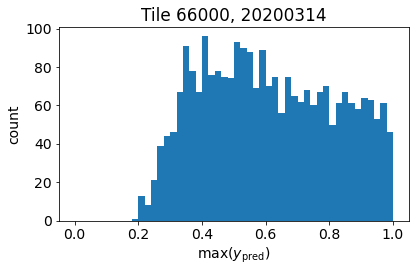

In [118]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
ax.hist(ymax, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count',
       title='Tile {}, {}'.format(tile_id, obsdate));

### Selection on Classifier Output

To be conservative we can select only spectra where the classifier is very confident in its output, e.g., ymax > 0.99. See the [CNN training notebook](https://github.com/desihub/timedomain/blob/master/desitrip/docs/nb/cnn_multilabel-restframe.ipynb) for the motivation behind this cut.

In [124]:
idx = np.argwhere(ymax > 0.99)
labels = np.argmax(pred, axis=1)

In [125]:
idx.shape

(19, 1)

In [126]:
# Randomly select 16 of the spectra and plot them.
selection = sorted(np.random.choice(idx.flatten(), size=16, replace=False))

0.12796538985535383
0.013748912227626843
0.25506857583278325
0.36468320816075467
0.36045455586167113
0.15534892936220615
0.4034336065301028
0.21009290012131826
0.25758541352635766
0.7685567962770793
0.31840248253822523
0.11039665926310184
0.1999158021840981
0.1789370868111838
0.4210215355237692
0.2563778296487622


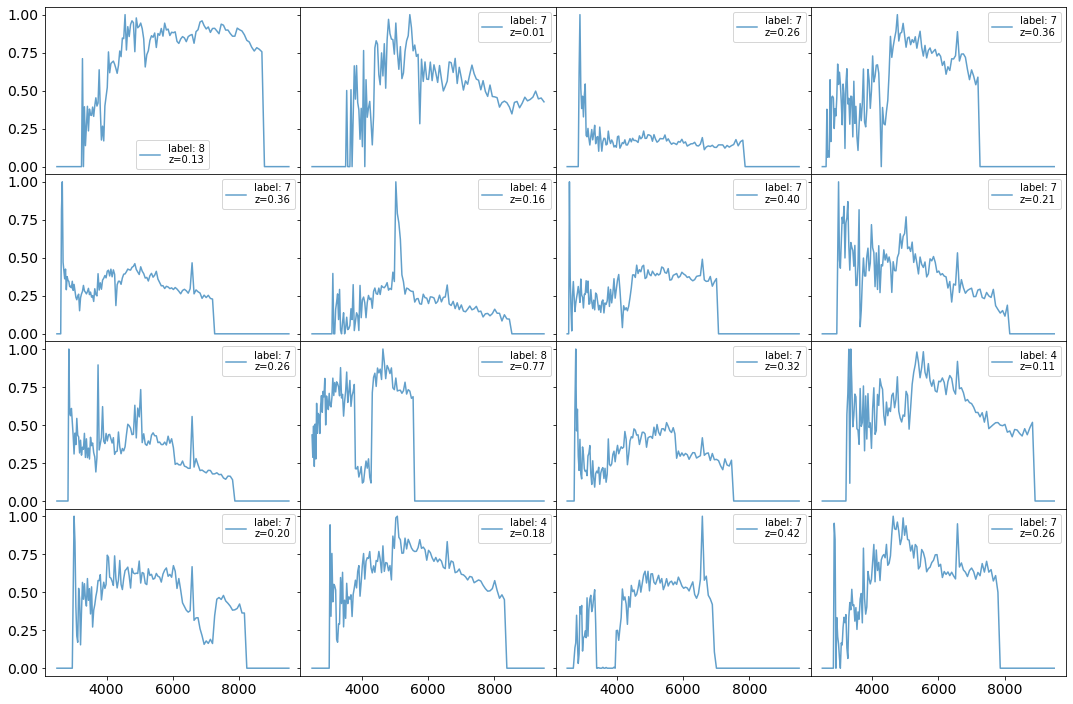

In [138]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(rewave, rsflux[j], alpha=0.7, label='label: {}\nz={:.2f}'.format(labels[j], allzbest[j]['Z']))
    print(allzbest[j]['Z'])
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();

In [139]:
testwave, testflux, testivar = rebin_flux(allwave, allflux, allivar,
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)

0.12796538985535383
0.013748912227626843
0.25506857583278325
0.36468320816075467
0.36045455586167113
0.15534892936220615
0.4034336065301028
0.21009290012131826
0.25758541352635766
0.7685567962770793
0.31840248253822523
0.11039665926310184
0.1999158021840981
0.1789370868111838
0.4210215355237692
0.2563778296487622


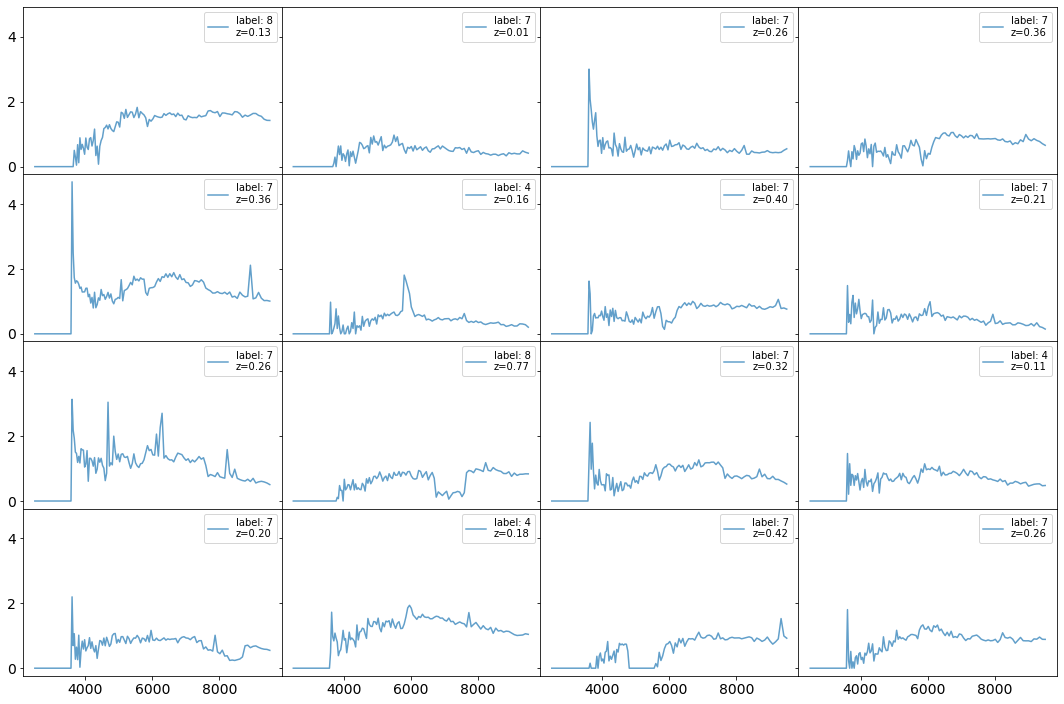

In [140]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(testwave, testflux[j], alpha=0.7, label='label: {}\nz={:.2f}'.format(labels[j], allzbest[j]['Z']))
    print(allzbest[j]['Z'])
    ax.legend(fontsize=10)

# for k in [0,1,2]:
#     axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#     axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
#                   xlim=(3500,9900))
fig.tight_layout();

In [141]:
idx

array([[  23],
       [  99],
       [ 515],
       [ 530],
       [ 609],
       [ 642],
       [ 723],
       [ 730],
       [ 862],
       [1039],
       [1040],
       [1167],
       [1182],
       [1305],
       [1346],
       [1579],
       [2411],
       [2426],
       [2476]])

In [144]:
allfmap[609]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int64,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64
35190944420597419,2,81,2081,1274,0,216.23055804330218,34.622934471197325,0.0,0.0,0.0,0.0,0.0,5400.0,256,1,TGT,155.12483,-92.11976,0,10000,0.7190027677838118,65535,100,8001,518390,2161p345,3755,REX,460931920000.0,495543980000.0,0.011219671,3.379395,6.937374,10.423504,331.99625,145.56847,98.54945,0.96733296,0.97787595,0.98756385,0.0,0.0,0.0,0.008477836,0.007234626,0.009298617,0.996539,0.9974114,0.9998964,3,3,3,595.3819,251.59889,169.10493,423.44073,167.86615,81.45692,11.123857,8.197101,50.670284,453.0044,3.9210799,0.756751,0.0018595384,2.2319427e-05,0.9981004,0.998833,0.999751,0.99990594,0,0,0,2.249883,4.618661,6.9396043,2.249883,4.618661,6.9396043,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.27826062,0.0,0.0,27611.193,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,N,256,2100,1,10515,0.0,0.0,0.0,0.0,0,0,0,3,155.061,-92.078,0.00125,0.0014999999999999996,0.0,0.0,4,0.003840572873934304,0.006284902544988267,1274,1274,1
